In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# read the data into a dataframe
data = pd.read_csv(r'marketing_AB.csv')
data.head(20)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
9,9,1446284,ad,False,142,Monday,14


https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

About Dataset
Marketing A/B testing dataset
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

In [9]:
data.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


convert all columns to int64

In [14]:
data['test group'].replace(['ad','psa'],[1,0], inplace = True)
data['converted'].replace([True,False],[1,0], inplace = True)
data['most ads day'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Unnamed: 0     588101 non-null  int64
 1   user id        588101 non-null  int64
 2   test group     588101 non-null  int64
 3   converted      588101 non-null  int64
 4   total ads      588101 non-null  int64
 5   most ads day   588101 non-null  int64
 6   most ads hour  588101 non-null  int64
dtypes: int64(7)
memory usage: 31.4 MB


Exploratory Analysis

<AxesSubplot:xlabel='most ads hour', ylabel='count'>

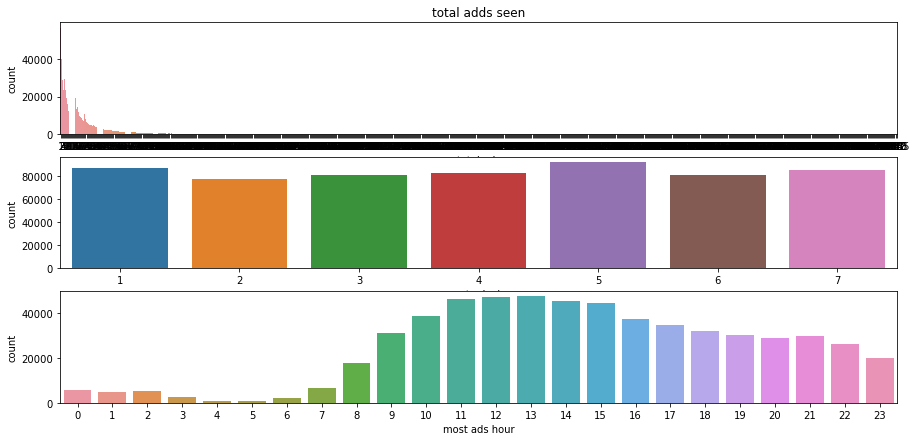

In [40]:
# visualizing distributions of key features

# make these graphs pretty

fig, ax = plt.subplots(3,1, figsize = (15,7))
sns.countplot(ax = ax[0],x = 'total ads', data = data).set(title='total adds seen')
sns.countplot(ax = ax[1],x = 'most ads day', data = data)
sns.countplot(ax = ax[2],x = 'most ads hour', data = data)



In [43]:
print(data.groupby('test group')['converted'].mean())

test group
0    0.017854
1    0.025547
Name: converted, dtype: float64
